# American Housing Stock
Classifying Adequate Units Based on Neighborhood Characteristics

## Table of Contents
1. <a href ='#goal'>Problem Statement</a>
2. <a href='#terms'>Key Terminology</a>
3. <a href='#datasources'>Data Sources</a>
4. <a href='#EDA'>Exploratory Data Analysis</a>
5. <a href='#models'>Classification</a>
 1. <a href='#model1'>Logistic Regression</a> 
 2. <a href='#model2'>Random Forest</a>
 3. <a href='#model3'>SVM</a>
6. <a href='#findings'>Recommendations</a>
7. <a href='#recs'>Next Steps</a>

In [2]:
# Import libraries and set defaults
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from collections import Counter

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
color_palette(palette='flatui', n_colors=8)
from yellowbrick.style import set_palette
set_palette('pastel')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('RdBu')
np.random.seed(42)

import warnings 
warnings.filterwarnings('ignore')

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<a id='goal'></a>
## Problem Statement

This analysis aims to assist the U.S. Department of Housing and Urban Development (HUD) to better understand the adequacy of housing units based on neighborhood characteristics.  To evaluate this topic, HUD aims to address the following question: **What neighborhood characteristics are important for classifying units as adequate?**

<a id='terms'></a>
## Key Terminology

- **U.S. Department of Housing & Urban Development (HUD)**:  federal agency dedicated to strengthening and supporting the housing market; primary responsibilities include:
  -  Protecting housing consumers
  -  Encouraging production of affordable rental housing
  -  Preventing and punishing discrimination in housing
- **Housing stock**:  total number of houses, apartments, or other dwellings
- **Housing unit**:  a single house, apartment, or other dwelling

<a id='datasources'></a>
## Data Sources

### American Housing Survey (AHS)
(https://www.census.gov/programs-surveys/ahs.html)

-  Biennial voluntary longitudinal survey that provides current and ongoing series of data on the size, composition, and state of housing in the United States and changes in the housing stock over time
-  Collects housing statistics that the U.S. Department of Housing and Urban Development (HUD) uses to evaluate and develop its federal housing programs
-  Sample size dependent on HUD budget and has varied over the years (e.g. in 2009 about 62,000 addresses were selected for the National survey)
-  Each sample unit from the basic sample has been visited every other year since 1985. New addresses are added to the sample at each iteration to ensure representativeness 

In [2]:
# import data
clean_df = pd.read_csv('data/ahs.csv')

<a id='EDA'></a>
## Exploratory Data Analysis

In [51]:
%run py_files/classification

In [3]:
# Create dummy model
X = clean_df.drop(['ADEQUACY_BIN'], axis=1)
y = clean_df.ADEQUACY_BIN

X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_labels = list(X.columns)

In [4]:
# always predicts the most frequent label in the training set
dummy0 = DummyClassifier(strategy='most_frequent')
dummy0.fit(X_train0, y_train0)
dummy0.score(X_test0, y_test0)

0.9316156093176541

In [3]:
sns.set_context('talk')
cm = ConfusionMatrix(dummy0, cmap='RdBu', title='Confusion Matrix (Dummy)');
cm.score(X_test0, y_test0);
cm.poof();

NameError: name 'dummy0' is not defined

The Dummy Classifier assigned all units to the predicted class 'adequate', indicating the need to balance sample count between the classes 'adequate' and 'inadequate.'  For this purpose, we employed SMOTE to create synthetic datapoints within the 'inadequate' class.

In [6]:
# Balancing classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 62185, 0: 62185})


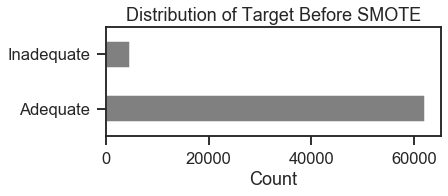

In [52]:
SMOTE_graph(y,'Distribution of Target Before SMOTE')

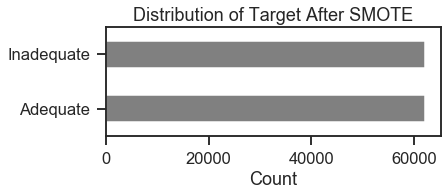

In [53]:
SMOTE_graph(y_res,'Distribution of Target After SMOTE')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

<a id='models'></a>
## Classification

<a id='model1'></a>
### 1)  Logistic Regression

In [10]:
# Creating a pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('clf',  LogisticRegression(random_state=42, solver='saga'))])

In [11]:
param_grid = dict(clf__penalty=['l1', None],
                  clf__C=[.001, 0.01, .1, 1, 10])

grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)

In [12]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [13]:
pipe.steps[1] = ('clf',  LogisticRegression(random_state=42, solver='saga', C=10, penalty='l1'))
pipe.fit(X_train,y_train)
clf_lr = pipe.named_steps['clf']

In [57]:
feats = {}
for feature, importance in zip(X_labels, clf_lr.coef_[0]):
    feats[feature] = importance

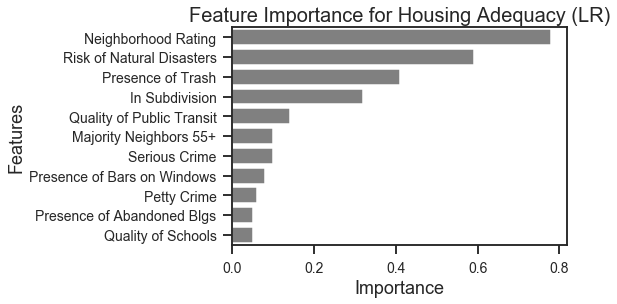

In [58]:
features_graph_nb(feats,'LR')

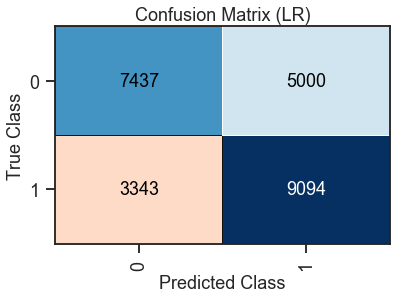

In [32]:
sns.set_context('talk')
cm = ConfusionMatrix(pipe, cmap='RdBu', title='Confusion Matrix (LR)');
cm.score(X_test, y_test);
cm.poof();

In [34]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64     12437
           1       0.65      0.73      0.69     12437

    accuracy                           0.66     24874
   macro avg       0.67      0.66      0.66     24874
weighted avg       0.67      0.66      0.66     24874



<a id='model2'></a>
### 2)  Random Forest

In [35]:
pipe.steps[1] = ('clf', RandomForestClassifier(random_state=42))

param_grid = dict(clf__n_estimators = [80,100,120],
                  clf__max_depth = [20,25,30])

grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [36]:
pipe.steps[1] = ('clf',  RandomForestClassifier(max_depth=25, n_estimators=100, random_state=42))
pipe.fit(X_train,y_train)
clf_rf = pipe.named_steps['clf']

In [59]:
feats = {}
for feature, importance in zip(X_labels, clf_rf.feature_importances_):
    feats[feature] = importance

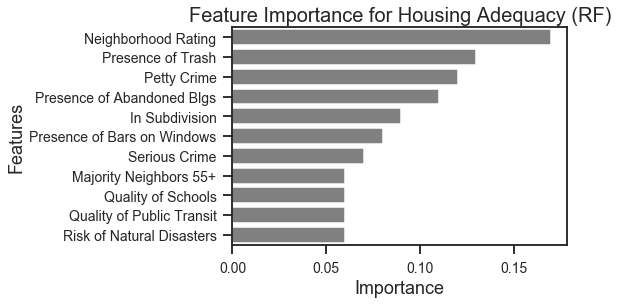

In [60]:
features_graph_nb(feats,'RF')

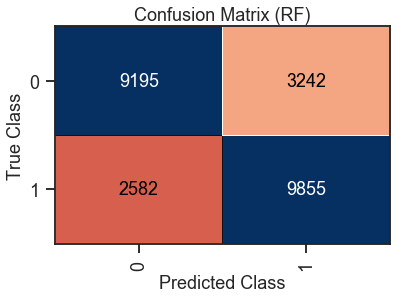

In [41]:
sns.set_context('talk')
cm = ConfusionMatrix(pipe, cmap='RdBu', title='Confusion Matrix (RF)');
cm.score(X_test, y_test);
cm.poof();

In [42]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     12437
           1       0.75      0.79      0.77     12437

    accuracy                           0.77     24874
   macro avg       0.77      0.77      0.77     24874
weighted avg       0.77      0.77      0.77     24874



<a id='model3'></a>
### 3)  SVM

In [63]:
pipe.steps[1] = ('clf', SVC(random_state=42))

param_grid = dict(clf__C = [0.1, 1],
                  clf__gamma = ['scale','auto'])

grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
pipe.steps[1] = ('clf',  SVC(random_state=42))
pipe.fit(X_train,y_train)
clf_svm = pipe.named_steps['clf']

In [ ]:
feats = {}
for feature, importance in zip(X_labels, clf_svm.coef_):
    feats[feature] = importance

In [ ]:
features_graph_nb(feats,'RF')

In [ ]:
plt.figure(figsize=(2,5))
ax = sns.barplot(y='Features', x='Importance', data=viz,color='gray');
plt.yticks(size=14);
plt.xticks(size=14);

In [ ]:
cm = ConfusionMatrix(grid_search, cmap='RdBu', title='Confusion Matrix (SVM)');
cm.score(X_test, y_test);
cm.poof();

In [ ]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

<a id='findings'></a>
## Recommendations

U.S. HUD can use this model as a portable solution to assess areas for further study with regards to housing adequacy based on neighborhood characteristics.

<a id='recs'></a>
## Next Steps

1. If needed, HUD could build models on other subsets of AHS features to use where full information is not available
2. HUD could also build models taking into account prior years' data
3. Compare to objective measures of features assessed in AHS